# Auto Sim Check

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.style.use('plotting.mplstyle')
box = dict(boxstyle = 'round, pad=0.25, rounding_size=0.25', facecolor='white', alpha=0.5, ec = 'None', )
box_inv = dict(boxstyle = 'round, pad=0.25, rounding_size=0.25', facecolor='k', alpha=0.5, ec = 'None', )

In [3]:
import logging

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_prominences

from kuibit.simdir import SimDir
from kuibit import argparse_helper as kah
from kuibit.hor_utils import compute_separation
from kuibit.hor_utils import compute_angular_velocity_vector
from kuibit.simdir import SimDir
from kuibit import grid_data as gd
from kuibit.visualize_matplotlib import (
    get_figname,
    save_from_dir_filename_ext,
    set_axis_limits_from_args,
    setup_matplotlib,
)

from scipy.signal import windows
from scipy.ndimage import gaussian_filter as gf


## Retrieve Data

In [193]:
sim_dir = "../simulations/"
sim_name = "DISK_A20_E015"
output_num = 123

sim_long = SimDir(sim_dir + sim_name)
hor_long = sim_long.horizons

print("Read in", sim_name)
# --- Cell ---
h1 = hor_long[(0,1)]
h2 = hor_long[(1,2)]


Read in DISK_A20_E015


In [194]:
# retrieve horizon positions and separation data

h1t = h1.ah.centroid_x.t
h1x = h1.ah.centroid_x.y
h1y = h1.ah.centroid_y.y
h1z = h1.ah.centroid_z.y

h2t = h2.ah.centroid_x.t
h2x = h2.ah.centroid_x.y
h2y = h2.ah.centroid_y.y
h2z = h2.ah.centroid_z.y

horizon_separation = compute_separation(h1, h2, resample=True)

In [186]:
# retrieve mdot data

mdot0 = sim_long.ts.scalar["flux_M0[0]"]
mdot1 = sim_long.ts.scalar["flux_M0[1]"]

# time
t = mdot0.t

# y values
m1 = -mdot0.y
m2 = -mdot1.y

# sum and normalize
mtot = m1 + m2
mtot = mtot / np.mean(mtot)

# normalize individual timeseries
m1 = m1 / np.mean(mtot)
m2 = m2 / np.mean(mtot)


In [187]:
# retrieve poyn flux data

poyn=sim_long.ts.scalar["outflow_poyn_flux[7]"]
poyn_t = poyn.t
poyn_y = poyn.y / np.mean(mtot)

In [188]:
sim_dir = "../simulations/"
sim_name = "DISK_A20_E015"
output_num = 123

sim = SimDir(sim_dir + sim_name + "/output-%04d" % output_num)
hor = sim.horizons

print("Read in", sim_name)
# --- Cell ---
h1 = hor[(0,1)]
h2 = hor[(1,2)]


Read in DISK_A20_E015


In [189]:
resolution = 500 #args.resolution
shape = [resolution, resolution]

xmax = 75
x0 = [-xmax,-xmax]
x1 = [xmax,xmax]

resample = True

vmin = 1e-5
vmax = 1e0

# retrieve rho xy and xz data
reader_xy = sim.gridfunctions["xy"]
reader_xz = sim.gridfunctions["xz"]

var_rho_xy = reader_xy["rho_b"]
var_rho_xz = reader_xz["rho_b"]


# interpolate xy data
data = var_rho_xy[var_rho_xy.available_iterations[-1]]

time = var_rho_xy.available_times[-1]
## converting data to 2D array
data_ufg = data.to_UniformGridData(
    shape=shape, x0=x0, x1=x1, resample=resample
)
if resample:
    new_grid = gd.UniformGrid(shape=shape, x0=x0, x1=x1)
    data_ufg_resample = data_ufg.resampled(
        new_grid, piecewise_constant=(not resample)
    )
coordinates = data_ufg_resample.coordinates_from_grid()
data_rho_xy = data_ufg_resample.data_xyz


# interpolate xz data
data = var_rho_xz[var_rho_xz.available_iterations[-1]]
## converting data to 2D array
data_ufg = data.to_UniformGridData(
    shape=shape, x0=x0, x1=x1, resample=resample
)
if resample:
    new_grid = gd.UniformGrid(shape=shape, x0=x0, x1=x1)
    data_ufg_resample = data_ufg.resampled(
        new_grid, piecewise_constant=(not resample)
    )
coordinates = data_ufg_resample.coordinates_from_grid()
data_rho_xz = data_ufg_resample.data_xyz

In [190]:
# get smallb2 data
var_smallb2_xy = reader_xy["smallb2"]
var_smallb2_xz = reader_xz["smallb2"]

# interpolate xy data
data = var_smallb2_xy[var_smallb2_xy.available_iterations[-1]]
## converting data to 2D array
data_ufg = data.to_UniformGridData(
    shape=shape, x0=x0, x1=x1, resample=resample
)
if resample:
    new_grid = gd.UniformGrid(shape=shape, x0=x0, x1=x1)
    data_ufg_resample = data_ufg.resampled(
        new_grid, piecewise_constant=(not resample)
    )
coordinates = data_ufg_resample.coordinates_from_grid()
data_smallb2_xy = data_ufg_resample.data_xyz


# interpolate xz data
data = var_smallb2_xz[var_smallb2_xz.available_iterations[-1]]
## converting data to 2D array
data_ufg = data.to_UniformGridData(
    shape=shape, x0=x0, x1=x1, resample=resample
)
if resample:
    new_grid = gd.UniformGrid(shape=shape, x0=x0, x1=x1)
    data_ufg_resample = data_ufg.resampled(
        new_grid, piecewise_constant=(not resample)
    )
coordinates = data_ufg_resample.coordinates_from_grid()
data_smallb2_xz = data_ufg_resample.data_xyz

In [191]:
# zoomed data
xmax = 25
x0_zoom = [-xmax,-xmax]
x1_zoom = [xmax,xmax]

data = var_rho_xy[var_rho_xy.available_iterations[-1]]

time = var_rho_xy.available_times[-1]
## converting data to 2D array
data_ufg = data.to_UniformGridData(
    shape=shape, x0=x0_zoom, x1=x1_zoom, resample=resample
)
if resample:
    new_grid = gd.UniformGrid(shape=shape, x0=x0_zoom, x1=x1_zoom)
    data_ufg_resample = data_ufg.resampled(
        new_grid, piecewise_constant=(not resample)
    )
coordinates = data_ufg_resample.coordinates_from_grid()
data_rho_xy_zoom = data_ufg_resample.data_xyz

data = var_smallb2_xy[var_smallb2_xy.available_iterations[-1]]
## converting data to 2D array
data_ufg = data.to_UniformGridData(
    shape=shape, x0=x0_zoom, x1=x1_zoom, resample=resample
)
if resample:
    new_grid = gd.UniformGrid(shape=shape, x0=x0_zoom, x1=x1_zoom)
    data_ufg_resample = data_ufg.resampled(
        new_grid, piecewise_constant=(not resample)
    )
coordinates = data_ufg_resample.coordinates_from_grid()
data_smallb2_xy_zoom = data_ufg_resample.data_xyz

## Make Figure

Text(0.5, 1.0, '$b^2/\\rho_0$')

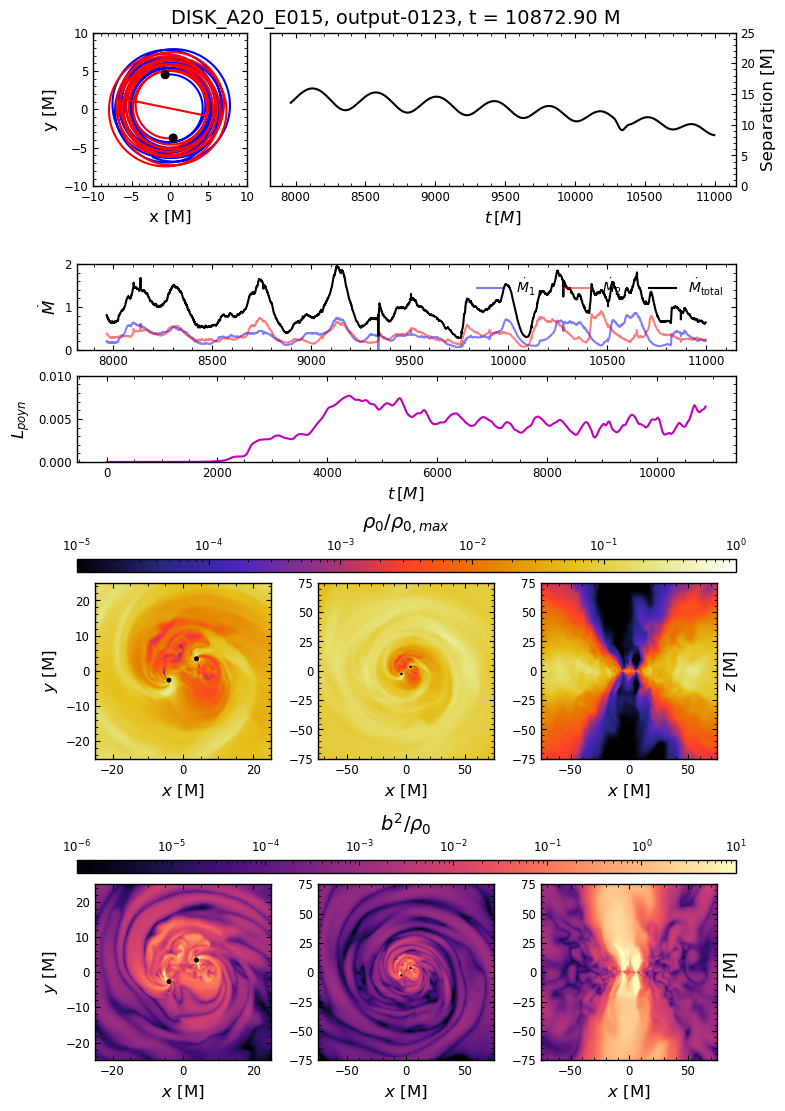

In [196]:
fig = plt.figure(figsize=(8.5, 11))

plt.tight_layout()

(hor, tseries, rho, mag) = fig.subfigures(4, 1, height_ratios=[0.75, 0.9, 1, 1], hspace=0)

hor.suptitle('%s, output-%04d, t = %.2f M' %(sim_name, output_num, time), fontsize=14)

tseries_axs = tseries.subplots(2, 1)
rho_axs = rho.subplots(1, 3)
mag_axs = mag.subplots(1, 3)

# plotting horizons
hor_axs = hor.subplots(1, 2, width_ratios=[1, 2.5])
hor.subplots_adjust(bottom=0.2, wspace=0.02)

ax = hor_axs[0]
ax.plot(h1x, h1y, color='b', lw=1.5)
ax.plot(h2x, h2y, color='r', lw=1.5)
ax.set_xlabel('x [M]')
ax.set_ylabel('y [M]')
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_aspect('equal', 'box')
circle1 = plt.Circle((h1x[-1], h1y[-1]), 0.5, color='k', zorder  = 2)
ax.add_patch(circle1)
circle2 = plt.Circle((h2x[-1], h2y[-1]), 0.5, color='k', zorder  = 2)
ax.add_patch(circle2)

ax = hor_axs[1]

ax.plot(horizon_separation, color='k', lw=1.5)
ax.set_ylim(0, 25)
ax.set_xlabel('$t \, [M]$')
ax.set_ylabel('Separation [M]')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# plotting mdot
ax = tseries_axs[0]
ax.plot(t, m1, color='b', lw=1.5, label=r'$\dot{M}_1$', alpha = 0.5)
ax.plot(t, m2, color='r', lw=1.5, label=r'$\dot{M}_2$', alpha = 0.5)
ax.plot(t, mtot, color='k', lw=1.5, label=r'$\dot{M}_{\rm total}$')

ax.set_ylim(0, 2)
ax.set_ylabel(r'$\dot{M}$')
ax.legend(loc='upper right', fontsize=10, framealpha=0.5, ncols = 3)

# plotting poynting flux
ax = tseries_axs[1]
ax.plot(poyn_t, poyn_y, color='m', lw=1.5)
ax.set_xlabel('$t \, [M]$')
ax.set_ylabel('$L_{poyn}$')
ax.set_ylim(0, 0.01)

tseries.subplots_adjust(bottom=0.15, wspace=0.01, hspace = 0.3)

# plotting rho
vmin = 1e-5
vmax = 1e0


ax = rho_axs[0]
im = ax.imshow(data_rho_xy_zoom, norm='log', origin='lower', extent=[x0_zoom[0], x1_zoom[0], x0_zoom[1], x1_zoom[1]], vmin=vmin, vmax=vmax, cmap='CMRmap')
ax.set_xlabel(r'$x$ [M]')
ax.set_ylabel(r'$y$ [M]')
arg_time1 = np.argmin(np.abs(h1t - time))
circle1 = plt.Circle((h1x[arg_time1], h1y[arg_time1]), 0.5, color='k', zorder  = 2)
ax.add_patch(circle1)
arg_time2 = np.argmin(np.abs(h2t - time))
circle2 = plt.Circle((h2x[arg_time2], h2y[arg_time2]), 0.5, color='k', zorder  = 2)
ax.add_patch(circle2)

ax = rho_axs[1]
im = ax.imshow(data_rho_xy, norm='log', origin='lower', extent=[x0[0], x1[0], x0[1], x1[1]], vmin=vmin, vmax=vmax, cmap='CMRmap')
ax.set_xlabel(r'$x$ [M]')
circle1 = plt.Circle((h1x[arg_time1], h1y[arg_time1]), 0.5, color='k', zorder  = 2)
ax.add_patch(circle1)
circle2 = plt.Circle((h2x[arg_time2], h2y[arg_time2]), 0.5, color='k', zorder  = 2)
ax.add_patch(circle2)

ax = rho_axs[2]
im2 = ax.imshow(data_rho_xz, norm='log', origin='lower', extent=[x0[0], x1[0], x0[1], x1[1]], vmin=vmin, vmax=vmax, cmap='CMRmap')
ax.set_xlabel(r'$x$ [M]')
ax.set_ylabel(r'$z$ [M]')
ax.yaxis.set_label_position("right")

rho.subplots_adjust(bottom=0.15, wspace=0.05)

cbar = fig.colorbar(im, ax=rho_axs, orientation='horizontal', pad=0.05, shrink = 1, aspect = 50, location='top')
cbar.ax.set_title(r'$\rho_0 / \rho_{0, max}$')

# plotting smallb2
vmin = 1e-6
vmax = 1e1

ax = mag_axs[0]
im = ax.imshow(data_smallb2_xy_zoom/data_rho_xy_zoom, norm='log', origin='lower', extent=[x0_zoom[0], x1_zoom[0], x0_zoom[1], x1_zoom[1]], vmin=vmin, vmax=vmax, cmap='magma')
ax.set_xlabel(r'$x$ [M]')
ax.set_ylabel(r'$y$ [M]')
circle1 = plt.Circle((h1x[arg_time1], h1y[arg_time1]), 0.5, color='k', zorder  = 2)
ax.add_patch(circle1)
circle2 = plt.Circle((h2x[arg_time2], h2y[arg_time2]), 0.5, color='k', zorder  = 2)
ax.add_patch(circle2)

ax = mag_axs[1]
im = ax.imshow(data_smallb2_xy/data_rho_xy, norm='log', origin='lower', extent=[x0[0], x1[0], x0[1], x1[1]], vmin=vmin, vmax=vmax, cmap='magma')
ax.set_xlabel(r'$x$ [M]')
circle1 = plt.Circle((h1x[arg_time1], h1y[arg_time1]), 0.5, color='k', zorder  = 2)
ax.add_patch(circle1)
circle2 = plt.Circle((h2x[arg_time2], h2y[arg_time2]), 0.5, color='k', zorder  = 2)
ax.add_patch(circle2)

ax = mag_axs[2]
im2 = ax.imshow(data_smallb2_xz/data_rho_xz, norm='log', origin='lower', extent=[x0[0], x1[0], x0[1], x1[1]], vmin=vmin, vmax=vmax, cmap='magma')
ax.set_xlabel(r'$x$ [M]')
ax.set_ylabel(r'$z$ [M]')
ax.yaxis.set_label_position("right")

mag.subplots_adjust(bottom=0.15, wspace=0.05)

cbar = fig.colorbar(im, ax=mag_axs, orientation='horizontal', pad=0.05, shrink = 1, aspect = 50, location='top')
cbar.ax.set_title(r'$b^2/\rho_0$')

#plt.savefig("%s_%s.pdf"%(sim_name, str(output_num).zfill(4)), bbox_inches='tight')